# **CASE III – An exploration of the impact of Vectorization on Classification**

**Problem Statement**

Does the type of vectorization selected have a significant impact on the performance of the classification models ?

## **Import Packages & Read dataset**

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [1]:
pip install NLTK

Note: you may need to restart the kernel to use updated packages.


In [2]:
# suppress warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# common imports
import pandas as pd
import numpy as np
import math
import re
import glob
import os
import sys
import json
import random
import pprint as pp
import textwrap
import sqlite3
import logging
import time

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
#BASE_DIR = "/content/drive/MyDrive/Natural Language Processing/NLP Project"
#os.chdir(BASE_DIR)

In [3]:
file = "reviews_5_balanced.json"
df = pd.read_json(file, lines=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294240 entries, 0 to 294239
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   overall         294240 non-null  int64 
 1   verified        294240 non-null  bool  
 2   reviewTime      294240 non-null  object
 3   reviewerID      294240 non-null  object
 4   asin            294240 non-null  object
 5   reviewText      294240 non-null  object
 6   summary         294132 non-null  object
 7   unixReviewTime  294240 non-null  int64 
dtypes: bool(1), int64(2), object(5)
memory usage: 16.0+ MB
None


,overall,verified,reviewTime,reviewerID,asin,reviewText,summary,unixReviewTime
0,1,True,"03 12, 2018",A3QY3THQ42WSCQ,B000YFSR5G,Waaaay too BIG,One Star,1520812800
1,1,True,"03 12, 2018",A3QY3THQ42WSCQ,B000YFSR4W,Waaaay too BIG,One Star,1520812800
2,1,True,"02 8, 2017",A21HH0VIBKK80J,B000YFSR5G,"Was terribly disappointed, the pants were way ...","Was terribly disappointed, the pants were way ...",1486512000
3,1,True,"02 8, 2017",A21HH0VIBKK80J,B000YFSR4W,"Was terribly disappointed, the pants were way ...","Was terribly disappointed, the pants were way ...",1486512000
4,1,True,"02 19, 2018",A276HQXYS553QW,B0014F8TIU,Constantly rolls down,One Star,1518998400


## **Data Exploration**

In [4]:
df.summary

0                                                  One Star
1                                                  One Star
2         Was terribly disappointed, the pants were way ...
3         Was terribly disappointed, the pants were way ...
4                                                  One Star
                                ...                        
294235                                           Five Stars
294236                                           Five Stars
294237                                           Five Stars
294238                                 Love the kick stand.
294239                                       flavoerd cofee
Name: summary, Length: 294240, dtype: object

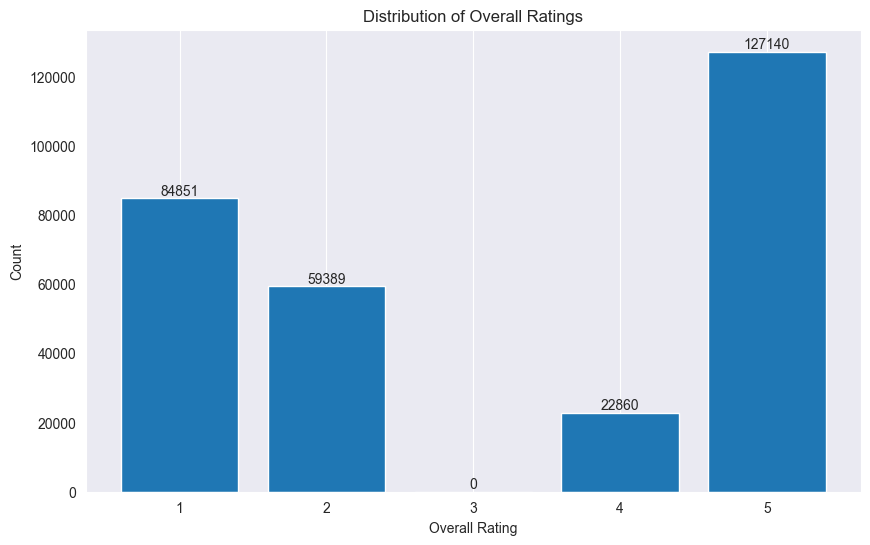

In [5]:
plt.figure(figsize=(10, 6))
overall_counts = df['overall'].value_counts().sort_index()

# Reindex the overall_counts to include a '3' and set any missing index to 0
reindexed_counts = overall_counts.reindex(range(1, 6), fill_value=0)
x_positions = np.arange(len(reindexed_counts))
bars = plt.bar(x_positions, reindexed_counts.values)

# Set the x-tick labels to show all ratings
plt.xticks(x_positions, reindexed_counts.index)

# Annotate each bar with its count
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, '%d' % int(height), ha='center', va='bottom')

# Plot
plt.xlabel('Overall Rating')
plt.ylabel('Count')
plt.title('Distribution of Overall Ratings')
plt.grid(axis='y')
plt.show()

In [6]:
# Create the 'outcome' column based on 'overall' rating
df['outcome'] = df['overall'].apply(lambda x: 0 if x <= 2 else 1 if x in [4, 5] else None)
df.head(2)

,overall,verified,reviewTime,reviewerID,asin,reviewText,summary,unixReviewTime,outcome
0,1,True,"03 12, 2018",A3QY3THQ42WSCQ,B000YFSR5G,Waaaay too BIG,One Star,1520812800,0
1,1,True,"03 12, 2018",A3QY3THQ42WSCQ,B000YFSR4W,Waaaay too BIG,One Star,1520812800,0


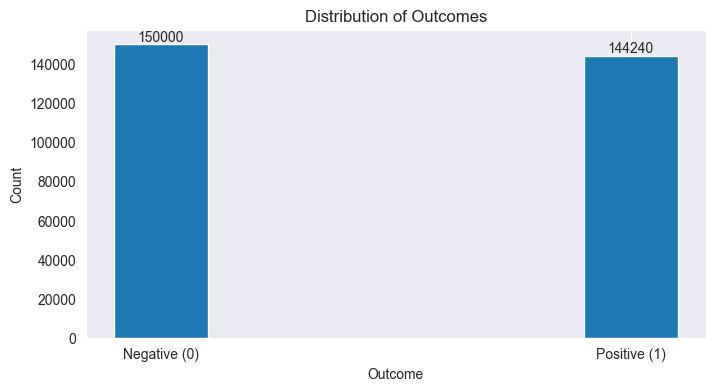

In [7]:
bar_width = 0.2
plt.figure(figsize=(8, 4))
outcome_counts = df['outcome'].value_counts()
bars = plt.bar(outcome_counts.index.astype(str), outcome_counts.values, width=bar_width)  # Add the width parameter here

# Annotate each bar with its count
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, '%d' % int(yval), ha='center', va='bottom')

# Plot
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.title('Distribution of Outcomes')
plt.xticks([0, 1], ['Negative (0)', 'Positive (1)'])  # Set the x-ticks to correspond to the outcome labels
plt.grid(axis='y')
plt.show()

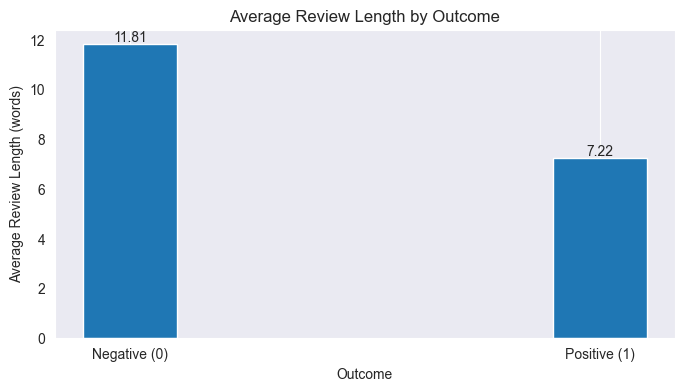

In [8]:
bar_width = 0.2
df['review_length'] = df['reviewText'].str.split().str.len()
average_lengths = df.groupby('outcome')['review_length'].mean()
plt.figure(figsize=(8, 4))
bars = plt.bar(average_lengths.index.astype(str), average_lengths.values, width=bar_width)

# Annotate each bar with its count
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f}', ha='center', va='bottom')

# Plot
plt.xlabel('Outcome')
plt.ylabel('Average Review Length (words)')
plt.title('Average Review Length by Outcome')
plt.xticks([0, 1], ['Negative (0)', 'Positive (1)']) 
plt.grid(axis='y')
plt.show()

## **Preprocessing**

In [9]:
# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Load English stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /Users/weimengng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/weimengng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/weimengng/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
def preprocess_text(text):
    # Tokenize text
    tokens = word_tokenize(text)
    # Convert to lowercase, lemmatize, and remove stopwords and punctuation
    tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens if token.isalpha() and token.lower() not in stop_words]
    return ' '.join(tokens)

In [11]:
# Apply the preprocessing function to the reviewText column
df['processed_reviewText'] = df['reviewText'].apply(preprocess_text)
df[['reviewText', 'processed_reviewText']].head()

,reviewText,processed_reviewText
0,Waaaay too BIG,waaaay big
1,Waaaay too BIG,waaaay big
2,"Was terribly disappointed, the pants were way ...",terribly disappointed pant way large leg husba...
3,"Was terribly disappointed, the pants were way ...",terribly disappointed pant way large leg husba...
4,Constantly rolls down,constantly roll


## **Vectorization**

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294240 entries, 0 to 294239
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   overall               294240 non-null  int64 
 1   verified              294240 non-null  bool  
 2   reviewTime            294240 non-null  object
 3   reviewerID            294240 non-null  object
 4   asin                  294240 non-null  object
 5   reviewText            294240 non-null  object
 6   summary               294132 non-null  object
 7   unixReviewTime        294240 non-null  int64 
 8   outcome               294240 non-null  int64 
 9   review_length         294240 non-null  int64 
 10  processed_reviewText  294240 non-null  object
dtypes: bool(1), int64(4), object(6)
memory usage: 22.7+ MB


#### **Bag of Words with TF-IDF**

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [14]:
%%time

# Appear in at least 5 documents and in no more than 70% of all documents are included
tfidf_text_vectorizer = TfidfVectorizer(min_df=5, max_df=0.7) 
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['processed_reviewText'])
tfidf_text_vectors.shape # 9378 Vocabulary

CPU times: user 2.19 s, sys: 23.7 ms, total: 2.22 s
Wall time: 2.25 s


(294240, 9378)

In [15]:
# Convert sparse matrix to dense matrix
dense_tfidf_vectors = tfidf_text_vectors.toarray()

# Convert to DataFrame
df_tfidf = pd.DataFrame(dense_tfidf_vectors, columns=tfidf_text_vectorizer.get_feature_names_out())
df_tfidf.head()

,aa,aaa,aaaa,aaaaa,ab,abd,ability,abit,able,abrasive,...,zinc,zinnia,zip,zipper,zj,zombie,zone,zoom,zte,zucchini
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### **Topic Modeling with NMF**

In [ ]:
from sklearn.decomposition import NMF

In [ ]:
%%time

# 100 dimensions
nmf_text_model = NMF(n_components=100, random_state=42)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [ ]:
tfidf_text_vectors.shape, W_text_matrix.shape, H_text_matrix.shape

In [ ]:
W_text_matrix

In [ ]:
H_text_matrix

In [ ]:
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1]
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

In [ ]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())

#### **GloVe**

In [ ]:
try:
  from gensim.utils import simple_preprocess
except:
  %pip install gensim
  from gensim.utils import simple_preprocess

In [ ]:
def load_glove_embeddings(path):
    """
    Load GloVe word embeddings from a file into a dictionary.
    
    Args:
    path (str): The file path to the GloVe embeddings file.
    
    Returns:
    dict: A dictionary with words as keys and embedding vectors as values.
    """
    embeddings_index = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Load glove embeddings file
glove_path = 'glove.6B.100d.txt'  
glove_embeddings = load_glove_embeddings(glove_path)

In [ ]:
# Tokenize preprocessed texts
df['tokenized_text'] = df['processed_reviewText'].apply(lambda x: simple_preprocess(x))

# Function to create document vectors
def document_vector_glove(doc, glove_embeddings):
    """
    Create a document vector by averaging the GloVe vectors of the words in the document.

    Args:
        doc (list of str): The tokenized document.
        glove_embeddings (dict): A dictionary of word to GloVe vector mappings.

    Returns:
        ndarray: The averaged document vector.
    """    
    doc = [word for word in doc if word in glove_embeddings]
    if not doc:
        return np.zeros(100)  
    else:
        return np.mean([glove_embeddings[word] for word in doc], axis=0)

# Creat document vector for each review; store in numpy array
df['doc_vector'] = df['tokenized_text'].apply(lambda doc: document_vector_glove(doc, glove_embeddings))
X_glove = np.array(df['doc_vector'].tolist())

In [ ]:
X_glove

## **Classification**

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

### **TF-IDF**

#### **Random Forest**

In [ ]:
%%time

# Cross Validation with 5 folds
model_rf = RandomForestClassifier(random_state=42)
scores = cross_val_score(estimator=model_rf,
                         X=tfidf_text_vectors,
                         y=df['outcome'],
                         n_jobs=-1,
                         cv=5)

print ("Validation scores from each iteration of the cross validation for Random Forest", scores)
print ("Mean value across of validation scores for Random Forest", scores.mean())
print ("Standard deviation of validation scores for Random Forest", scores.std())

#### **Support Vector Machine**

In [ ]:
%%time

# Cross-validation with 5 folds
model_svm = SVC(random_state=42)
scores_svm = cross_val_score(estimator=model_svm,
                             X=tfidf_text_vectors,
                             y=df['outcome'],
                             n_jobs=-1,
                             cv=5)

print("Validation scores from each iteration of the cross validation for SVM: ", scores_svm)
print("Mean value across of validation scores for SVM: ", scores_svm.mean())
print("Standard deviation of validation scores for SVM: ", scores_svm.std())

#### **Naive Bayes**

In [ ]:
%%time

# Cross-validation with 5 folds
model_nb = MultinomialNB()
scores_nb = cross_val_score(estimator=model_nb,
                            X=tfidf_text_vectors,
                            y=df['outcome'],
                            cv=5,
                            n_jobs=-1)

print("Validation scores from each iteration of the cross validation for Naive Bayes: ", scores_nb)
print("Mean value across of validation scores for Naive Bayes: ", scores_nb.mean())
print("Standard deviation of validation scores for Naive Bayes: ", scores_nb.std())

#### **Gradient Boosting**

In [ ]:
%%time

# Cross-validation with 5 folds
model_gb = GradientBoostingClassifier(random_state=42)
scores_gb = cross_val_score(estimator=model_gb,
                            X=tfidf_text_vectors,
                            y=df['outcome'],
                            cv=5,
                            n_jobs=-1)

print("Validation scores from each iteration of the cross validation for Gradient Boosting: ", scores_gb)
print("Mean value across of validation scores for Gradient Boosting: ", scores_gb.mean())
print("Standard deviation of validation scores for Gradient Boosting: ", scores_gb.std())

### **NMF**

In [ ]:
# %%time

# Define classifiers
#classifiers = {"Random Forest": RandomForestClassifier(random_state=42),
 #   "SVM": SVC(random_state=42),
  #  "Naive Bayes": MultinomialNB(), 
   # "Gradient Boosting": GradientBoostingClassifier(random_state=42),
#}

# Cross-validation with 5 folds
#for name, classifier in classifiers.items():
 #   scores = cross_val_score(classifier, W_text_matrix, df['outcome'], n_jobs=-1, cv=5)
 #   print(f"{name} Accuracy: {scores.mean():.6f} (+/- {scores.std() * 2:.6f})")

In [ ]:
# Define classifiers
classifiers = {"Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42),
    "Naive Bayes": MultinomialNB(), 
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
}

# Cross-validation with 5 folds
for name, classifier in classifiers.items():
    start_cpu = time.process_time()  # Start time for measuring CPU time
    scores = cross_val_score(classifier, W_text_matrix, df['outcome'], n_jobs=-1, cv=5)
    end_cpu = time.process_time()  # End time for measuring CPU time
    cpu_time = end_cpu - start_cpu
    
    print("------")
    print(f"{name} Accuracy: {scores.mean():.6f} (+/- {scores.std() * 2:.6f})")
    print(f"{name} CPU time: {cpu_time:.2f} seconds")

### **GloVe**

In [ ]:
# Define classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
}

# Cross-validation with 5 folds
for name, classifier in classifiers.items():
    start_cpu = time.process_time() 
    scores = cross_val_score(classifier, X_glove, df['outcome'], n_jobs=-1, cv=5)
    end_cpu = time.process_time() 
    cpu_time = end_cpu - start_cpu
    
    print("------")
    print(f"{name} Accuracy: {scores.mean():.6f} (+/- {scores.std() * 2:.6f})")
    print(f"{name} CPU time: {cpu_time:.2f} seconds")

## **Hyperparameter Tuning (GridSearch CV)**

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score

In [17]:
###USE THIS

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import time

# Assuming X_glove and df['outcome'] are prepared
X = tfidf_text_vectors
y = df['outcome']

# Parameter grid setup
n_estimators = [10, 100, 250]
max_depths = [20, 50, 100, None]

results = []

for n_estimator in n_estimators:
    for max_depth in max_depths:
        start_cpu_time = time.process_time()
        
        # Create and fit the model manually
        model = RandomForestClassifier(n_estimators=n_estimator, max_depth=max_depth, random_state=42)
        scores = cross_val_score(model, X, y, cv=5, n_jobs=-1)
        
        end_cpu_time = time.process_time()
        
        # Append results
        results.append({
            'n_estimators': n_estimator,
            'max_depth': max_depth,
            'mean_score': np.mean(scores),
            'std_score': np.std(scores),
            'cpu_time': end_cpu_time - start_cpu_time
        })

# Find the best result based on the mean score
best_result = max(results, key=lambda x: x['mean_score'])

# Print the best parameters and the corresponding score
print("Best parameters:")
best_params = {k: best_result[k] for k in ['n_estimators', 'max_depth']}
print(best_params)
print("\nBest score:")
print(best_result['mean_score'])

# Print other scores including CPU times
print("\nGrid scores:")
for result in results:
    print("------")
    params = f"n_estimators: {result['n_estimators']}, max_depth: {result['max_depth']}"
    print(f"{params}, Accuracy: {result['mean_score']:.6f} (+/- {result['std_score'] * 2:.6f}), CPU Time: {result['cpu_time']:.3f} seconds")


Best parameters:
{'n_estimators': 250, 'max_depth': None}

Best score:
0.8437126155519306

Grid scores:
------
n_estimators: 10, max_depth: 20, Accuracy: 0.724925 (+/- 0.103573), CPU Time: 0.247 seconds
------
n_estimators: 10, max_depth: 50, Accuracy: 0.767741 (+/- 0.096476), CPU Time: 0.112 seconds
------
n_estimators: 10, max_depth: 100, Accuracy: 0.808629 (+/- 0.054805), CPU Time: 0.180 seconds
------
n_estimators: 10, max_depth: None, Accuracy: 0.834533 (+/- 0.051301), CPU Time: 0.372 seconds
------
n_estimators: 100, max_depth: 20, Accuracy: 0.762741 (+/- 0.101388), CPU Time: 0.177 seconds
------
n_estimators: 100, max_depth: 50, Accuracy: 0.801682 (+/- 0.101397), CPU Time: 0.402 seconds
------
n_estimators: 100, max_depth: 100, Accuracy: 0.828252 (+/- 0.048356), CPU Time: 0.956 seconds
------
n_estimators: 100, max_depth: None, Accuracy: 0.843118 (+/- 0.051512), CPU Time: 2.909 seconds
------
n_estimators: 250, max_depth: 20, Accuracy: 0.761786 (+/- 0.089135), CPU Time: 0.424 se

### **Parameter Tuning of RF with TF-IDF vectorizer (accounting for ngrams)**

In [ ]:
%%time

# Define pipeline with TF-IDF vectorizer and classifier step
pipeline_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer()),  # Add the TF-IDF vectorizer
    ('clf', RandomForestClassifier(random_state=42))
])

# Define the parameter grid, including n-gram ranges for the TF-IDF vectorizer
param_grid_tfidf = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],  # Testing unigrams, bigrams, and trigrams
    'clf__n_estimators': [10, 100, 250],
    'clf__max_depth': [20, 50, 100, None],
}

grid_search_tfidf = GridSearchCV(pipeline_tfidf, param_grid_tfidf, cv=5, n_jobs=-1, verbose=1)
grid_search_tfidf.fit(df['processed_reviewText'], df['outcome'])
results = grid_search_tfidf.cv_results_

# Print the best parameters and the corresponding score
print("Best parameters:")
print(grid_search_tfidf.best_params_)
print("\nBest score:")
print(grid_search_tfidf.best_score_)

# Print other scores
print("\nGrid scores:")
for i in range(len(results['params'])):
    print("------")
    name = ', '.join([f"{key.split('__')[-1]}: {value}" for key, value in results['params'][i].items()])
    mean_score = results['mean_test_score'][i]
    std_score = results['std_test_score'][i]
    print(f"{name} Accuracy: {mean_score:.6f} (+/- {std_score * 2:.6f})")

In [19]:
## USE THIS

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
import numpy as np
import time

X = df['processed_reviewText']  # Use raw text data here, not tfidf_text_vectors
y = df['outcome']

# Simplified parameter setup
ngram_ranges = [(1, 1), (1, 2), (1, 3)]

# Fixed parameters based on your choice
n_estimator = 10
max_depth = None

results = []

for ngram_range in ngram_ranges:
    start_cpu_time = time.process_time()
    
    # Define and fit the pipeline for each n-gram range
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=ngram_range,min_df=5, max_df=0.7)),
        ('clf', RandomForestClassifier(n_estimators=n_estimator, max_depth=max_depth, random_state=42))
    ])
    scores = cross_val_score(pipeline, X, y, cv=5, n_jobs=-1)
    
    end_cpu_time = time.process_time()
    
    # Append results
    results.append({
        'ngram_range': ngram_range,
        'mean_score': np.mean(scores),
        'std_score': np.std(scores),
        'cpu_time': end_cpu_time - start_cpu_time
    })

# Find the best result based on the mean score
best_result = max(results, key=lambda x: x['mean_score'])

# Print the best parameters and the corresponding score
print("Best n-gram range:")
print(best_result['ngram_range'])
print("\nBest score:")
print(best_result['mean_score'])

# Print other scores including CPU times
print("\nGrid scores:")
for result in results:
    print("------")
    ngram_range = result['ngram_range']
    print(f"ngram_range: {ngram_range}, Accuracy: {result['mean_score']:.6f} (+/- {result['std_score'] * 2:.6f}), CPU Time: {result['cpu_time']:.3f} seconds")


Best n-gram range:
(1, 3)

Best score:
0.8384584013050571

Grid scores:
------
ngram_range: (1, 1), Accuracy: 0.835036 (+/- 0.046756), CPU Time: 1.155 seconds
------
ngram_range: (1, 2), Accuracy: 0.837952 (+/- 0.047651), CPU Time: 1.271 seconds
------
ngram_range: (1, 3), Accuracy: 0.838458 (+/- 0.046310), CPU Time: 1.385 seconds


### **Parameter Tuning of RF with NMF vectorizer**

In [ ]:
%%time

# Define pipeline with classifier step
pipeline_nmf = Pipeline([
    ('clf', RandomForestClassifier(random_state=42))
])

# Define parameter grid
param_grid_nmf = {
    'clf__n_estimators': [10, 100, 250],
    'clf__max_depth': [20, 50, 100, None],
}

grid_search_nmf = GridSearchCV(pipeline_nmf, param_grid_nmf, cv=5, n_jobs=-1, verbose=1)
grid_search_nmf.fit(W_text_matrix, df['outcome'])
results = grid_search_nmf.cv_results_

# Print the best parameters and the corresponding score
print("Best parameters:")
print(grid_search_nmf.best_params_)
print("\nBest score:")
print(grid_search_nmf.best_score_)

# Print other scores
print("\nGrid scores:")
for i in range(len(results['params'])):
    print("------")
    name = ', '.join([f"{key.split('__')[-1]}: {value}" for key, value in results['params'][i].items()])
    mean_score = results['mean_test_score'][i]
    std_score = results['std_test_score'][i]
    print(f"{name} Accuracy: {mean_score:.6f} (+/- {std_score * 2:.6f})")

In [ ]:
import time
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Assuming W_text_matrix and df['outcome'] are your dataset and labels
X = W_text_matrix
y = df['outcome']

# Define your parameter grid manually
n_estimators_options = [10, 100, 250]
max_depth_options = [20, 50, 100, None]

results = []

# Manually iterate through the parameter grid
for n_estimators in n_estimators_options:
    for max_depth in max_depth_options:
        start_cpu_time = time.process_time()
        
        # Define and fit the model for each combination
        clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        scores = cross_val_score(clf, X, y, cv=5, n_jobs=-1)
        
        end_cpu_time = time.process_time()
        
        # Store results
        results.append({
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'mean_score': np.mean(scores),
            'std_score': np.std(scores),
            'cpu_time': end_cpu_time - start_cpu_time
        })

# Find the best result based on the mean score
best_result = max(results, key=lambda x: x['mean_score'])

# Print the best parameters and the corresponding score
print("Best parameters:")
best_params = {k: best_result[k] for k in ['n_estimators', 'max_depth']}
print(best_params)
print("\nBest score:")
print(best_result['mean_score'])

# Print other scores including CPU times
print("\nGrid scores:")
for result in results:
    print("------")
    params = f"n_estimators: {result['n_estimators']}, max_depth: {result['max_depth']}"
    print(f"{params}, Accuracy: {result['mean_score']:.6f} (+/- {result['std_score'] * 2:.6f}), CPU Time: {result['cpu_time']:.3f} seconds")

### **Parameter Tuning of RF with GloVe vectorizer**

In [ ]:
%%time

# Define pipeline with classifier step
pipeline_glove = Pipeline([
    ('clf', RandomForestClassifier(random_state=42))
])

# Define parameter grid
param_grid_glove = {
    'clf__n_estimators': [10, 100, 250],
    'clf__max_depth': [20, 50, 100, None],
}

grid_search_glove = GridSearchCV(pipeline_glove, param_grid_glove, cv=5, n_jobs=-1, verbose=1)
grid_search_glove.fit(X_glove, df['outcome'])
results = grid_search_glove.cv_results_

# Print the best parameters and the corresponding score
print("Best parameters:")
print(grid_search_glove.best_params_)
print("\nBest score:")
print(grid_search_glove.best_score_)

# Print other scores
print("\nGrid scores:")
for i in range(len(results['params'])):
    print("------")
    name = ', '.join([f"{key.split('__')[-1]}: {value}" for key, value in results['params'][i].items()])
    mean_score = results['mean_test_score'][i]
    std_score = results['std_test_score'][i]
    print(f"{name} Accuracy: {mean_score:.6f} (+/- {std_score * 2:.6f})")

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import time

# Assuming X_glove and df['outcome'] are prepared
X = X_glove
y = df['outcome']

# Parameter grid setup
n_estimators = [10, 100, 250]
max_depths = [20, 50, 100, None]

results = []

for n_estimator in n_estimators:
    for max_depth in max_depths:
        start_cpu_time = time.process_time()
        
        # Create and fit the model manually
        model = RandomForestClassifier(n_estimators=n_estimator, max_depth=max_depth, random_state=42)
        scores = cross_val_score(model, X, y, cv=5, n_jobs=-1)
        
        end_cpu_time = time.process_time()
        
        # Append results
        results.append({
            'n_estimators': n_estimator,
            'max_depth': max_depth,
            'mean_score': np.mean(scores),
            'std_score': np.std(scores),
            'cpu_time': end_cpu_time - start_cpu_time
        })

# Find the best result based on the mean score
best_result = max(results, key=lambda x: x['mean_score'])

# Print the best parameters and the corresponding score
print("Best parameters:")
best_params = {k: best_result[k] for k in ['n_estimators', 'max_depth']}
print(best_params)
print("\nBest score:")
print(best_result['mean_score'])

# Print other scores including CPU times
print("\nGrid scores:")
for result in results:
    print("------")
    params = f"n_estimators: {result['n_estimators']}, max_depth: {result['max_depth']}"
    print(f"{params}, Accuracy: {result['mean_score']:.6f} (+/- {result['std_score'] * 2:.6f}), CPU Time: {result['cpu_time']:.3f} seconds")
